In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
    MaxAbsScaler,
    OneHotEncoder,
    LabelEncoder,
    Normalizer,
)
from sklearn.metrics import mean_absolute_error,mean_squared_error,accuracy_score
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV,RidgeClassifier,RidgeClassifierCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,VotingClassifier,BaggingClassifier,RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier,XGBRFClassifier
from catboost import CatBoostClassifier,CatBoost
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
import wandb
np.random.seed(42)

In [2]:
PROJECT_NAME = 'Titanic-V3'

In [3]:
def validate(model,X,y):
    preds = model.predict(X)
    results = {
        'Acc':accuracy_score(y,preds),
        'MAE':mean_absolute_error(y,preds),
        'MSE':mean_squared_error(y,preds)
    }
    return results
def fit_model(model,X_train,y_train,X_test,y_test,name):
    wandb.init(project=PROJECT_NAME,name=name)
    try:
        model = model()
    except:
        model = model
    model.fit(X_train,y_train)
    results = validate(model,X_train,y_train)
    for key,val in zip(results.keys(),results.values()):
        wandb.log({key:val})
    results = validate(model,X_test,y_test)
    for key,val in zip(results.keys(),results.values()):
        wandb.log({'Val ' + key:val})
    wandb.finish()
    return model

In [4]:
data = pd.read_csv('./train.csv')
data = data.sample(frac=1)
test_data = pd.read_csv('./test.csv')
sample_sub = pd.read_csv('./gender_submission.csv')

In [5]:
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
data['Age'].fillna(data['Age'].mean(),inplace=True)

In [7]:
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,29.699118,1,1,2661,15.2458,NaN,C
439,440,0,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.000000,0,0,C.A. 18723,10.5000,NaN,S
840,841,0,3,"Alhomaki, Mr. Ilmari Rudolf",male,20.000000,0,0,SOTON/O2 3101287,7.9250,NaN,S
720,721,1,2,"Harper, Miss. Annie Jessie ""Nina""",female,6.000000,0,1,248727,33.0000,NaN,S
39,40,1,3,"Nicola-Yarred, Miss. Jamila",female,14.000000,1,0,2651,11.2417,NaN,C


In [9]:
data.drop('Cabin',axis=1,inplace=True)

In [10]:
new_tickets = []
for ticket in data['Ticket']:
    try:
        ticket = int(ticket.split(' ')[0])
    except:
        try:
            ticket = int(ticket.split(' ')[1])
        except:
            try:
                ticket = int(ticket.split(' ')[2])
            except:
                ticket = np.mean(new_tickets)
    new_tickets.append(ticket)
data['Ticket'] = new_tickets

In [11]:
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket         float64
Fare           float64
Embarked        object
dtype: object

In [12]:
new_names = []
for name in data['Name']:
    new_names.append(name.split(', ')[1].split('.')[0])
data['Name'] = new_names

In [13]:
X = data.drop('Survived',axis=1)
y = data['Survived']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.125)

In [14]:
from sklearn.compose import make_column_transformer

In [15]:
len(data.drop(['Name','Sex','Embarked'],axis=1).columns)

8

In [16]:
data.drop(['Pclass','Fare'],axis=1,inplace=True)

In [17]:
ohe = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'),['Name','Sex','Embarked']),
#     (StandardScaler(),['PassengerId', 'Age', 'SibSp', 'Parch', 'Ticket','Fare'])
    remainder='passthrough'
)
ohe.fit(X_train)
X_train = ohe.transform(X_train)

In [18]:
X_train[1]

array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
       0.00000e+00, 5.10000e+02, 3.00000e+00, 2.60000e+01, 0.00000e+00,
       0.00000e+00, 1.60100e+03, 5.64958e+01])

In [19]:
X_test = ohe.transform(X_test)

In [20]:
# model = fit_model(GradientBoostingClassifier,X_train,y_train,X_test,y_test,'baseline')

In [21]:
# for col in ['Pclass']:
#     max_num = data[col].quantile(0.99)
#     min_num = data[col].quantile(0.05)
#     data = data[data[col] < max_num]
#     data = data[data[col] > min_num]
#     print(len(data))
#     X = data.drop('Survived',axis=1)
#     y = data['Survived']
#     X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5)
#     ohe = make_column_transformer(
#         (OneHotEncoder(handle_unknown='ignore'),['Name','Sex','Embarked']),
#         remainder='passthrough'
#     )
#     ohe.fit(X_train)
#     X_train = ohe.transform(X_train)
#     X_test = ohe.transform(X_test)
# fit_model(GradientBoostingClassifier,X_train,y_train,X_test,y_test,f'baseline')

In [22]:
pres = [StandardScaler(),RobustScaler(),MinMaxScaler(),MaxAbsScaler(),OneHotEncoder(),Normalizer()]

In [23]:
X = data.drop('Survived',axis=1)
y = data['Survived']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5)
ohe = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'),['Name','Sex','Embarked']),
    remainder='passthrough'
)
ohe.fit(X_train)
X_train = ohe.transform(X_train)
X_test = ohe.transform(X_test)

In [24]:
models = [
    ['KNeighborsClassifier',KNeighborsClassifier],
    ['LogisticRegression',LogisticRegression],
    ['LogisticRegressionCV',LogisticRegressionCV],
    ['RidgeClassifier',RidgeClassifier],
    ['RidgeClassifierCV',RidgeClassifierCV],
    ['GaussianNB',GaussianNB],
    ['DecisionTreeClassifier',DecisionTreeClassifier],
    ['GradientBoostingClassifier',GradientBoostingClassifier],
    ['AdaBoostClassifier',AdaBoostClassifier],
    ['RandomForestClassifier',RandomForestClassifier],
    ['BaggingClassifier',BaggingClassifier],
    ['SVC',SVC],
    ['XGBClassifier',XGBClassifier],
    ['XGBRFClassifier',XGBRFClassifier],
    ['CatBoostClassifier',CatBoostClassifier],
]

In [25]:
# for model in models:
#     fit_model(model[1],X_train,y_train,X_test,y_test,f'{model[0]}')

In [26]:
from sklearn.model_selection import GridSearchCV

In [29]:
model = RandomForestClassifier(bootstrap=True,class_weight='balanced',criterion= 'entropy',max_features= 'log2',n_estimators= 500,oob_score= True,warm_start= True)
model = fit_model(model,X_train,y_train,X_test,y_test,f'Final')
import pickle
pickle.dump(model,open('./model.pkl','wb'))

wandb: Currently logged in as: ranuga-d (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.11.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/indika/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:587: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


Acc,1.0
_runtime,7
_timestamp,1628444891
_step,5
MAE,0.0
MSE,0.0
Val Acc,0.81839
Val MAE,0.18161
Val MSE,0.18161


Acc,▁
_runtime,▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁
_step,▁▂▄▅▇█
MAE,▁
MSE,▁
Val Acc,▁
Val MAE,▁
Val MSE,▁


In [31]:
test_data.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [32]:
test_data.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [33]:
del test_data['Cabin']

In [34]:
new_tickets = []
for ticket in test_data['Ticket']:
    try:
        ticket = int(ticket.split(' ')[0])
    except:
        try:
            ticket = int(ticket.split(' ')[1])
        except:
            try:
                ticket = int(ticket.split(' ')[2])
            except:
                ticket = np.mean(new_tickets)
    new_tickets.append(ticket)
test_data['Ticket'] = new_tickets

In [35]:
new_names = []
for name in test_data['Name']:
    new_names.append(name.split(', ')[1].split('.')[0])
test_data['Name'] = new_names

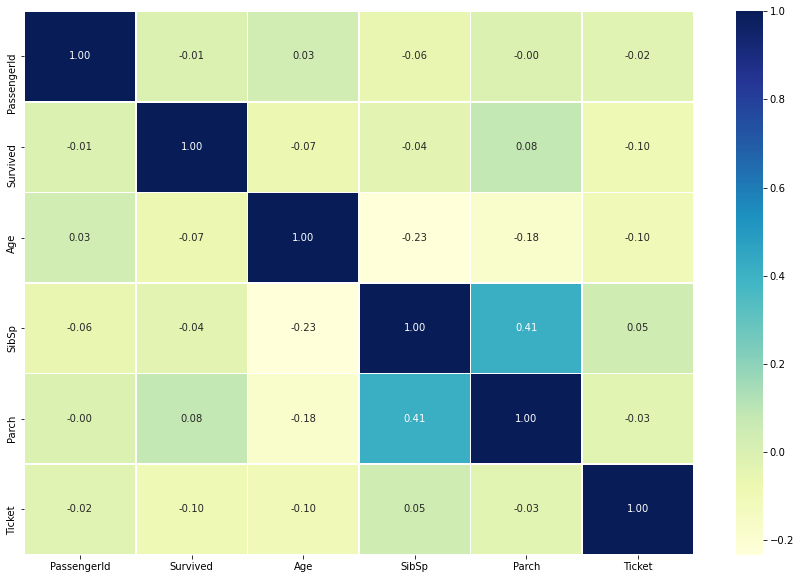

In [36]:
corr_matrix = data.corr()
fig,ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,annot=True,linewidths=0.5,fmt='.2f',cmap='YlGnBu')

In [37]:
test_data.drop(['Pclass','Fare'],axis=1,inplace=True)

In [38]:
ids = pd.read_csv('./test.csv')['PassengerId']

In [39]:
test_data['Age'] = test_data['Age'].fillna(test_data['Age'].mean())

In [40]:
test_data.isna().sum()

PassengerId    0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Embarked       0
dtype: int64

In [41]:
test_data = ohe.transform(test_data)

In [42]:
preds = model.predict(test_data)

In [43]:
sample_sub

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [44]:
df = pd.DataFrame({'PassengerId':ids,'Survived':preds})

In [45]:
df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,1
4,896,1


In [46]:
df.to_csv('./submission-0.csv',index=False)

In [47]:
from sklearn.model_selection import cross_val_score

In [48]:
np.mean(cross_val_score(model,X_train,y_train,cv=100))

/home/indika/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:587: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/home/indika/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:587: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class 

0.8195

In [ ]:
np.mean(cross_val_score(model,X_test,y_test,cv=100))

/home/indika/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:587: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/home/indika/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:587: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class 